# Setup Instructions
In order to be able to run the Jupyter Notebook in Google Colab you have to run the following code cell.
Otherwise you won't be able to use the helper functions as well as importing the necessary preprocessed data.
- Clone the GitHub repository:

```python
!git clone https://github.com/LukasEijk/AdvancedDeepLearning.git


import sys
sys.path.append('/content/AdvancedDeepLearning/')

import os
os.chdir('AdvancedDeepLearning')

```


# Jet tagging with transformers

Today we will build a transformer network for jet classification.

Some tips:
- you should use the TransformerEncoder class in pytorch
- do not use very many encoder layers or a larger model dimension, this will be very heavy to run
- do some tests starting with small TransformerEncoders to find something suitable
- getting the best performance is not the important thing here, we just want to understand the network
- if you have questions/problems, check pytorch documentation and/or forums, or talk to each other
- if there's still problems, we can discuss during the tutorial

Some interesting papers:
- Attention Is All You Need
    - https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf
- Symmetries, Safety, and Self-Supervision
    - https://arxiv.org/abs/2108.04253
- Particle Transformer for Jet Tagging
    - https://arxiv.org/abs/2202.03772

Outline:
- Imports and plotting set-up
- Building the dataset
    - Preprocessing
    - Dataloaders
- The self-attention mechanism
- Jets and self-attention
- The TransformerEncoder
- Building a Transformer classifier
- Optimising the Transformer classifier
- Study the results

### Imports

In [1]:
import os
import sys
import random
import time
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from torch.nn import Sequential, Linear, ReLU

In order to make your life easier we give you some helper functions to use

In [2]:
from src.plotting_setup import *
from src.dataloader import *

## Loading the data

We'll be using the top-tagging data, so let's just load them.

In [3]:
y_train = np.load( "data/toptagging-short/y_train_short.npy")
y_test = np.load( "data/toptagging-short/y_test_short.npy")
y_val = np.load( "data/toptagging-short/y_val_short.npy")

For each jet we'll keep the $50$ constituents with the highest $p_T$, with each constituent consisting of $(p_T,\eta,\phi)$.
So each constituent in the jet has three features.

The z datasets have been already preprocessed for you here. So we just load them in. 

In [4]:
z_train = np.load('data/z_train.npy')
z_val = np.load('data/z_val.npy')
z_test = np.load('data/z_test.npy')


In [5]:
print( "Train data shape: " + str(z_train.shape) )
print( "Val data shape: " + str(z_val.shape) )
print( "Test data shape: " + str(z_test.shape) )

Train data shape: (30000, 50, 3)
Val data shape: (30000, 50, 3)
Test data shape: (30000, 50, 3)


Now we want to convert all the numpy arrays into `torch.Tensor`s 

In [6]:
z_train_p = torch.Tensor( z_train )
z_val_p = torch.Tensor( z_val )
z_test_p = torch.Tensor( z_test )
y_train_p = torch.Tensor( y_train )
y_val_p = torch.Tensor( y_val )
y_test_p = torch.Tensor( y_test )

### Dataloaders

In [7]:
trn_dataset = topcloud_dataset( z_train_p, y_train_p.unsqueeze(-1) )
val_dataset = topcloud_dataset( z_val_p, y_val_p.unsqueeze(-1) )
tst_dataset = topcloud_dataset( z_test_p, y_test_p.unsqueeze(-1) )

In [8]:
trn_dataloader = DataLoader( trn_dataset, batch_size=64, shuffle=True )
val_dataloader = DataLoader( val_dataset, batch_size=64, shuffle=True )
tst_dataloader = DataLoader( tst_dataset, batch_size=64, shuffle=True )

## The self-attention mechanism

The self-attention mechanism takes $N$ input vectors and outputs $N$ vectors.  The output is permutation equivariant, i.e. there is a one-to-one map from each input vector to a single output vector, and if we were to change the ordering of the input vectors, the ordering of the output vectors would change in the same way.  The output vectors aim to provide a better representation of the input data by taking into account interactions between vectors in the input.  The dimension of the input and output vectors are in general different also.

In the 'Attention Is All You Need' paper they describe attention as:

"An attention function can be described as mapping a query and a set of key-value pairs to an output,
where the query, keys, values, and output are all vectors. The output is computed as a weighted sum
of the values, where the weight assigned to each value is computed by a compatibility function of the
query with the corresponding key."

### Scaled dot-product attention

There are many forms of attention, we use the scaled dot-product attention, defined as:

$
\text{Attention}(Q,K,V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$

where $Q$, $K$, and $V$ are the query, key, and value vectors.
The query and key vectors have dimension $d_k$ and the value vectors have dimension $d_v$.

The self-attention mechanism is built using three matrices:
- Query matrix
- Key matrix
- Value matrix

They all have dimension ``input_dim`` x ``embed_dim``.
In the transformer the parameters of these matrices are learned through back-propagation.

### Multi-headed self-attention

The self-attention mechanism we just described has a single head, i.e. one set of query/key/value matrices to project from the input to the output.  Multi-headed self-attention does the same projection but with multiple sets of query/key/value matrices.  Let's say the embedding dimension we want is 20, and we choose 4 heads.  This means we will have 4 attention-mechanisms, each projecting the input data to a 5 dimensional output.  These outputs are then appended together to produce the 20 dimensional embedding.  When using multi-headed self-attention we need to ensure that the embedding dimension is exactly divisible by the number of heads.

## Jets and self-attention

Jets will have a data dimension of ``noc``x$3$, where ``noc`` is just the number of constituents.  So let's say $50$x$3$ if we restrict to the 50 hardest constituents.

This means that the input dimension is $3$.

### An example

Let's create a fake jet with 10 constituents.

In [9]:
jet = torch.rand( ??? )

Let's have a look at `jet`

In [10]:
jet

tensor([[0.7211, 0.8062, 0.1614],
        [0.2621, 0.8041, 0.2880],
        [0.8840, 0.8770, 0.3268],
        [0.7389, 0.5800, 0.8827],
        [0.2412, 0.3718, 0.0795],
        [0.4992, 0.0474, 0.9434],
        [0.6787, 0.3290, 0.7652],
        [0.2458, 0.5002, 0.8293],
        [0.3724, 0.1973, 0.4675],
        [0.9331, 0.3225, 0.8295]])

The input dim is obviously 3, and we can define the embed_dim to be whatever we like.

In [11]:
input_dim = 3
embed_dim = ???

In practice the query, key, and value matrices consist of learnable parameters that are optimised during training.  But to demonstrate the self-attention mechanism here we will just initialise them randomly.

Use `torch.randn()` for doing so.

In [12]:
w_query = torch.rand( ( input_dim, embed_dim ) )
w_key = torch.rand( ( ??? )
w_value = torch.rand( ??? )

From these matrices we then contruct the queries, keys, and values.

To do that multiply `jet` with the randomly initiated Query, Key and Value.

Use `torch.einsum(' - write the contraction -', jet, w_...)` if possible. If more convenient to you, `torch.matmul()`also works.

In [13]:
queries = ???
keys = ???
values = ???

And check it has the correct shape.

In [14]:
queries.shape

torch.Size([10, 5])

We need the length of the queries vector for the computation, so we save it below.

In [15]:
dk = torch.Tensor( ??? )

We then compute the query-key matrix multiplication.

In [16]:
qkt =  ???

In [17]:
qkt.shape

torch.Size([10, 10])

The attention weights are just the softmax over this matrix, divided by the square root of the query dimension.

In [18]:
attn = torch.softmax( ??? , dim=-1 )

The shape here is 10 by 10, which makes sense because this matrix tells us how much attention each input pays to every other input.  Since we have 10 inputs this should make it 10 by 10.

In [19]:
attn.shape

torch.Size([10, 10])

The output of the self-attention mechanism is then just the attention matrix multiplied by the values.
Same applies, either use `torch.matmul()` or `torch.einsum()`

In [20]:
out =  ???
out

tensor([[0.9146, 1.1281, 0.8593, 0.3225, 0.7797],
        [0.8897, 1.0979, 0.8392, 0.3155, 0.7636],
        [0.9320, 1.1504, 0.8742, 0.3281, 0.7926],
        [0.9311, 1.1512, 0.8751, 0.3291, 0.7951],
        [0.8634, 1.0645, 0.8167, 0.3071, 0.7443],
        [0.8999, 1.1123, 0.8494, 0.3198, 0.7738],
        [0.9152, 1.1308, 0.8616, 0.3240, 0.7833],
        [0.8965, 1.1081, 0.8464, 0.3187, 0.7711],
        [0.8802, 1.0864, 0.8317, 0.3129, 0.7577],
        [0.9320, 1.1519, 0.8756, 0.3291, 0.7952]])

In [21]:
out.shape

torch.Size([10, 5])

This shape makes sense.  We started with a 10 by 3 input, projecting the input dimension to the embedding dimension.

This output is also permutation equivariant, i.e. if we change the ordering of the inputs (the constituents in the jet) then the same change will be reflected in the output.

To obtain a permutation invariant output we would simply need to sum over dimension zero here.

In [22]:
inv_out = torch.sum( ??? )

In [23]:
inv_out.shape

torch.Size([5])

## The transformer encoder

The first layer of a transformer encoder is the embedding layer, it is simply a linear projection of each input to a vector of length ``d_model``.
So if we have a jet with 50 constituents and $(p_t,\eta,\phi)$ values for each constituent, the embedding layer would project each constituent separately to a vector of length ``d_model``, so that the output of this layer has dimensions 50 by ``d_model``.
Note that it is the same linear neural network applied to each constituent in the jet.

After the embedding the data is passed through a TransformerEncoderLayer, defined in the torch.nn module.

In [24]:
from torch.nn import TransformerEncoderLayer as TEL

The documentation tells us:

TransformerEncoderLayer is made up of self-attn and feedforward network. This standard encoder layer is based on the paper “Attention Is All You Need”. Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez, Lukasz Kaiser, and Illia Polosukhin. 2017. Attention is all you need. In Advances in Neural Information Processing Systems, pages 6000-6010. Users may modify or implement in a different way during application.

This is kind of vague, but after looking at the code we see that there is a multi-headed self-attention layer followed by a dense neural network.  
The dense neural network acts individually on each constituent in the jet and has three layers with dimensions ``(d_model, dim_feedforward, d_model)``.
Note also that the TransformerEncoder assumes that the input dimension is the same as the embedding dimension, we'll deal with this later using an embedding layer.

The parameters we need to initialise a layer are as follows:

- d_model – the number of expected features in the input (required).

- nhead – the number of heads in the multiheadattention models (required).

- dim_feedforward – the dimension of the feedforward network model (default=2048).

- dropout – the dropout value (default=0.1).

- activation – the activation function of the intermediate layer, can be a string (“relu” or “gelu”) or a unary callable. Default: relu

- layer_norm_eps – the eps value in layer normalization components (default=1e-5).

- batch_first – If True, then the input and output tensors are provided as (batch, seq, feature). Default: False (seq, batch, feature).

- norm_first – if True, layer norm is done prior to attention and feedforward operations, respectivaly. Otherwise it’s done after. Default: False (after).

Let's test it:

In [25]:
encoder_layer = TEL( d_model=120, nhead=4, batch_first=True, dropout=0.0 )
src = torch.rand( 10, 50, 120 )
out = encoder_layer( src )

This means we have a batch of 10 jets with 50 constituents each and 120 features per jet.

In [26]:
out.shape

torch.Size([10, 50, 120])


### Permutation Equivariance
We can check the permutation equivariance of the output by permuting the constituents in the input and checking the output.

Permuting the input:

In [27]:
src1 = src.detach().clone()

In [28]:
src1[:,0] = src[:,1].detach().clone()
src1[:,1] = src[:,0].detach().clone()

Getting the output and permuting it:

In [29]:
out1 = encoder_layer( src1 )

In [30]:
out1_perm = out1.detach().clone()

out1_perm[:,0] = out1[:,1].detach().clone()
out1_perm[:,1] = out1[:,0].detach().clone()

There are tiny differences in precision which make a True/False comparison fail.  So instead I'll just check the sum over the absolute difference of the outputs vs the sum over the absolute values in the outputs.

In [31]:
print( "sum over abs output: " + str( ( out.abs() ).sum().detach().numpy() ) )
print( "sum over abs permuted output: " + str( ( out1_perm.abs() ).sum().detach().numpy() ) )
print( "sum over abs diffs: " + str( ( out1_perm  - out ).abs().sum().detach().numpy() ) )

sum over abs output: 49368.22
sum over abs permuted output: 49368.22
sum over abs diffs: 0.0028665345


Clearly we have permutation equivariance.

## Building a transformer classifier
In order to complete the `JetTransformer` class complete the second transformer layer `self.transformer_layer_2` such that its output can be fed into a Feed Forward Network called `self.head_network`.

Use one layer which go from `embed_dim` down to a single output in the `head_network`. 

In [32]:
class JetTransformer( torch.nn.Module ):
    
    def __init__( self, input_dim, embed_dim, num_heads ):
        super( JetTransformer, self ).__init__()
        
        self.lin_embed = nn.Linear( input_dim, embed_dim )
        
        self.transformer_layer_1 = TEL( d_model=embed_dim, nhead=num_heads, 
                                     batch_first=True, dropout=0.0, dim_feedforward=embed_dim )
        
        self.transformer_layer_2 = ??? 
        
        self.head_network = ???
                                        
    def forward( self, batch ):

        x = ???
        x = ???
        x = ???
        x = x.mean( dim=1 )
        x = ???

        return F.sigmoid( x )

Let's test it:

In [33]:
JT = JetTransformer( 3, 12, 3 )

This means we embed each constituent to a vector of length 12, and pass this through a self-attention machanism with 3 heads.

Now we test it with a batch of 10 fake jets, each containing 50 constituents.

In [34]:
jets = torch.rand( ( 10, 50, 3 ) )

And we forward pass as follows:

In [35]:
JT( jets )

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SigmoidBackward0>)

This makes sense, since we get one classification score per jet.

## Optimising the transformer classifier
To accelerate the training one can use GPU's when available. `cuda`for Nvidia Graphic Cards and `mps` for M1 chips and later from Apple. `mps` is not always giving a great performance improvement. 

In [36]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


Here we use the same functions we used before.

In [37]:
loss_fn = nn.BCELoss()

In [38]:
from tqdm import tqdm

def train_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    total_batches = len(dataloader)

    # Initialize tqdm progress bar
    progress_bar = tqdm(total=total_batches, desc="Training", unit="batch")

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # pass data through network
        pred = model(X)
        
        # compute loss
        loss = loss_fn(pred, y)

        # reset gradients in optimizer
        optimizer.zero_grad()
        
        # compute gradients
        loss.backward()
        
        # update weights with optimizer
        optimizer.step()
        
        # Update tqdm progress bar with the current loss
        progress_bar.set_postfix(loss=loss.item())
        progress_bar.update(1)

    # Close the progress bar
    progress_bar.close()


In [39]:
def val_pass( dataloader, model, loss_fn ):
    
    size = len( dataloader.dataset )
    num_batches = len( dataloader )
    vl = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model( X )
            vl += loss_fn( pred, y ).item()

    vl /= num_batches
    print( f"avg val loss per batch: {vl:>8f}" )
    
    return vl

def trn_pass( dataloader, model, loss_fn ):
    
    size = len( dataloader.dataset )
    num_batches = len( dataloader )
    tl = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model( X )
            tl += loss_fn( pred, y ).item()

    tl /= num_batches
    print( f"avg trn loss per batch: {tl:>8f}" )
    
    return tl

In [40]:
# a useful function to present things clearer
def separator():
    print( "-----------------------------------------------" )

epochs = 2 # was 25 before

# re-initialise the model and the optimizer
model = JetTransformer( 3, 12, 3 ).to(device)
learning_rate = 0.0005
optimizer = torch.optim.Adam( model.parameters(), lr=learning_rate )
separator()
print( "model architecture ")
separator()
print( model )

# track train and val losses
trn_losses = []
val_losses = []

start = time.time()
for t in range(epochs):
    separator()
    print( f"Epoch {t+1}" )
    separator()
    train_epoch( trn_dataloader, model, loss_fn, optimizer )
    separator()
    trn_loss = trn_pass( trn_dataloader, model, loss_fn )
    trn_losses.append( trn_loss )
    separator()
    val_loss = val_pass( val_dataloader, model, loss_fn )
    val_losses.append( val_loss )
    separator()
    print( "|" )
    
print("Done!")
print(f'It took {np.round((time.time()-start)/60,2)} minutes to train.')

-----------------------------------------------
model architecture 
-----------------------------------------------
JetTransformer(
  (lin_embed): Linear(in_features=3, out_features=12, bias=True)
  (transformer_layer_1): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=12, out_features=12, bias=True)
    )
    (linear1): Linear(in_features=12, out_features=12, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (linear2): Linear(in_features=12, out_features=12, bias=True)
    (norm1): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.0, inplace=False)
    (dropout2): Dropout(p=0.0, inplace=False)
  )
  (transformer_layer_2): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=12, out_features=12, bias=True)
    )
    (linear1): Linear(in

Training: 100%|██████████| 469/469 [00:06<00:00, 71.37batch/s, loss=0.619]


-----------------------------------------------
avg trn loss per batch: 0.599919
-----------------------------------------------
avg val loss per batch: 0.601800
-----------------------------------------------
|
-----------------------------------------------
Epoch 2
-----------------------------------------------


Training: 100%|██████████| 469/469 [00:06<00:00, 75.76batch/s, loss=0.396]


-----------------------------------------------
avg trn loss per batch: 0.529226
-----------------------------------------------
avg val loss per batch: 0.521570
-----------------------------------------------
|
Done!
It took 0.37 minutes to train.


## Study the results

In [41]:
from src.plotting import *

To study the results let's start by looking at the loss functions.

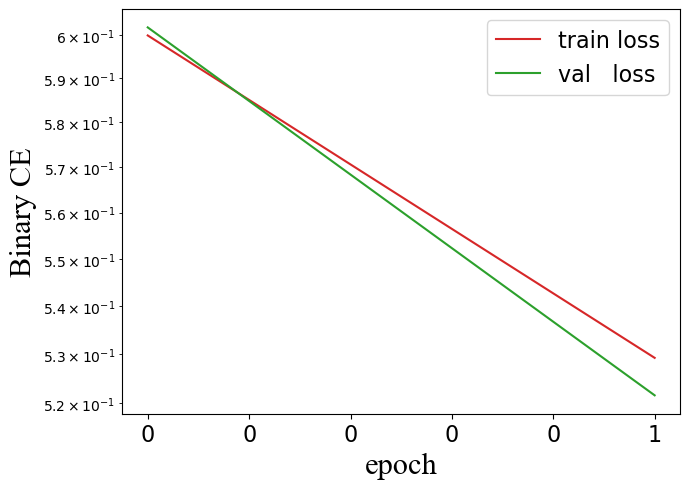

In [42]:
plot_loss(trn_losses,val_losses )

In [43]:
samp_size = 10000

# Ensure input data is on the same device as the model
z_train_tensor = torch.Tensor(z_train[:samp_size]).to(device)
z_test_tensor = torch.Tensor(z_test[:samp_size]).to(device)
z_val_tensor = torch.Tensor(z_val[:samp_size]).to(device)

train_pred = model(z_train_tensor).detach().cpu()
test_pred = model(z_test_tensor).detach().cpu()
val_pred = model(z_val_tensor).detach().cpu()

train_pred_lab = torch.round(train_pred[:samp_size])
test_pred_lab = torch.round(test_pred[:samp_size])
val_pred_lab = torch.round(val_pred[:samp_size])

train_correct = (np.array(train_pred_lab.squeeze(-1)) == y_train[:samp_size]).sum()
test_correct = (np.array(test_pred_lab.squeeze(-1)) == y_test[:samp_size]).sum()
val_correct = (np.array(val_pred_lab.squeeze(-1)) == y_val[:samp_size]).sum()

print(f"Train Correct: {train_correct}")
print(f"Test Correct: {test_correct}")
print(f"Validation Correct: {val_correct}")

Train Correct: 7313
Test Correct: 7181
Validation Correct: 7367


In [44]:
separator()
print('Evaluation of accuracy: ')
print('Accuracy on training dataset: {:.1f} %'.format(train_correct*100/len(train_pred)))
print('Accuracy on validation dataset: {:.1f} %'.format(val_correct*100/len(val_pred)))
print('Accuracy on test dataset: {:.1f} %'.format(test_correct*100/len(test_pred)))
separator()

-----------------------------------------------
Evaluation of accuracy: 
Accuracy on training dataset: 73.1 %
Accuracy on validation dataset: 73.7 %
Accuracy on test dataset: 71.8 %
-----------------------------------------------


Looks good!

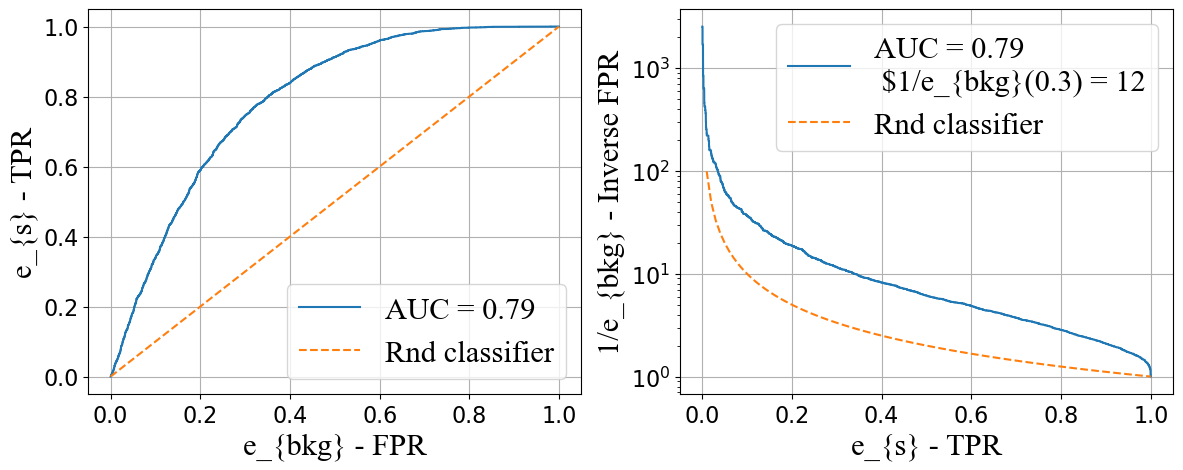

In [45]:
plot_roc_and_efficiency_curves(y_test, test_pred, samp_size)